In [1]:
library(pheatmap)  
library(tidyverse)
library(RColorBrewer)
library(viridis)
library(reshape2)
library(caret)

library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)

library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: viridisLite


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApp

In [2]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [3]:
annon_df = read.csv('../data/external/HOCOMOCOv11_annotation.csv',row.names=1)
head(annon_df)

,id,tf
,<fct>,<fct>
0,AHR_HUMAN.H11MO.0.B,AHR
1,AIRE_HUMAN.H11MO.0.C,AIRE
2,ALX1_HUMAN.H11MO.0.B,ALX1
3,ANDR_HUMAN.H11MO.0.A,AR
4,AP2A_HUMAN.H11MO.0.A,TFAP2A
5,AP2B_HUMAN.H11MO.0.B,TFAP2B


In [4]:
save_prefix = '../data/processed/fig6_footprinting/scc_'

# differential expression analysis

In [5]:
rna_files = as.array(list.files('../data/raw/rna/', pattern=('*/*.genes.results'),recursive=TRUE))
# data.frame(file_path = rna_files)
tissues = as.array(lapply(rna_files, function(x) strsplit(x, '/')[[1]][1]))
sample = as.array(lapply(rna_files, function(x) strsplit(x, '/')[[1]][2]))
sample = as.array(lapply(sample, function(x) strsplit(x, '.genes.results')[[1]][1]))

full_path = as.array(lapply(rna_files, function(x) paste0('../data/raw/rna/',x)))
                
rna_genes_result = data.frame("tissues" = tissues,"sample"=sample,"full_path"=full_path )  
rownames(rna_genes_result) = rna_genes_result$sample        
head(rna_genes_result  )                          

,tissues,sample,full_path
,<list>,<list>,<list>
A431-1-CTRLi,A431-CTRLi,A431-1-CTRLi,../data/raw/rna/A431-CTRLi/A431-1-CTRLi.genes.results
A431-2-CTRLi,A431-CTRLi,A431-2-CTRLi,../data/raw/rna/A431-CTRLi/A431-2-CTRLi.genes.results
A431-1-p63i,A431-p63i,A431-1-p63i,../data/raw/rna/A431-p63i/A431-1-p63i.genes.results
A431-2-p63i,A431-p63i,A431-2-p63i,../data/raw/rna/A431-p63i/A431-2-p63i.genes.results
Airway-B1,Airway,Airway-B1,../data/raw/rna/Airway/Airway-B1.genes.results
Airway-B2,Airway,Airway-B2,../data/raw/rna/Airway/Airway-B2.genes.results


In [6]:

createSig <- function (data, metadata, col_sel,tissue=TRUE, logFC_thres=.1, p_thres=0.05,max_return = 500) {
    # Differential expression analysis with limmma
    # This function takes in a target
    # Output is a result table of differential expression analysis for target vs control

    # load data and preprocess
#     metadata_sel <- labels_df %>% 
#         filter(control==control_id)%>%
#         filter(label == target | label == "control")%>%
#         dplyr::select(-control)    
#     rownames(metadata_sel) = metadata_sel$sample
#     data <- counts_all_filt[ ,rownames(metadata_sel) ]
#     log_data <- log2(data+1) 
    
#     metadata = data.frame("column" =cols_all)
    if (tissue){
    metadata = metadata %>% 
        mutate(label = if_else(tissues==col_sel, 'target', 'control'))
    }
    else{
         metadata = metadata %>% 
        mutate(label = if_else(group==col_sel, 'target', 'control'))
    }
    
    # set up the design
    labels <- factor(metadata$label)
    design <- model.matrix(~ labels + 1)
    colnames(design) <- levels(labels)
    rownames(design) <- metadata$tissue
    
#     print(design)

    # proceed with analysis
    fit <- lmFit(data, design)
    fit <- eBayes(fit, trend=TRUE)
    tT = topTable(fit, coef=ncol(design),adjust="fdr", sort.by="p", number=Inf)
    tT$gene = rownames(tT)
    tT = na.omit(tT)
    tT_filt = tT[tT$logFC>logFC_thres  & tT$adj.P.Val<p_thres,]
    tT_filt = tT_filt%>% arrange(desc(logFC))
#     print(dim(tT_filt))
    tT_filt = tT_filt[1:min(max_return, dim(tT_filt)[1]),]

  return(tT_filt)
}

In [7]:
rna_tpm_file_tissue = '../data/interim/rna/tissue_tpm_sym.csv'
rna_df_tissue = read.csv(rna_tpm_file_tissue, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_tissue_log = log2(rna_df_tissue+1e-2)
rna_df_tissue_norm = as.data.frame(scale(rna_df_tissue_log, center = TRUE, scale = TRUE))


In [8]:
rna_tpm_file = '../data/interim/rna/sample_tpm_sym.csv'
rna_df = read.csv(rna_tpm_file, row.names=1,stringsAsFactors=F,check.names = FALSE)
rna_df_log = log2(rna_df+1e-2)
rna_df_norm = as.data.frame(scale(rna_df_log, center = TRUE, scale = TRUE))
head(rna_df_norm)

,A431-1-CTRLi,A431-1-p63i,A431-2-CTRLi,A431-2-p63i,Airway-B1,Airway-B2,Astrocytes-B1,Astrocytes-B2,Bladder-B1,Bladder-B2,⋯,Uterine-B1,Uterine-B2,WM2664-SCR-DMSO-BR1,WM2664-SCR-DMSO-BR2,WM2664-SCR-PLX-BR1,WM2664-SCR-PLX-BR2,WM2664-shMITF-DMSO-BR1,WM2664-shMITF-DMSO-BR2,WM2664-shMITF-PLX-BR1,WM2664-shMITF-PLX-BR2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,0.6417831,0.6623433,0.7994448,0.7303720,0.6541822,0.7392987,1.1087689,1.1485692,0.65029894,0.7204134,⋯,0.61458326,0.5914140,1.5838919,1.6188556,1.6918717,1.7822770,1.675711913,1.6293048,1.70953587,1.74049731
A1BG-AS1,0.2892481,-0.5210944,-0.5150074,-0.5875764,-0.5020608,-0.4581187,-0.1194657,0.1052466,-0.46525912,-1.0460320,⋯,-0.50740969,-0.8272739,0.1171384,-0.2481127,-0.2092722,0.1470238,-0.004195876,-0.1286889,0.02483362,-0.07187348
A1CF,-1.0291413,-1.0467041,-1.0465532,-1.0575809,-1.0307378,-0.8255721,-0.9271780,-0.9030065,-0.71791710,-1.0460320,⋯,-1.04026653,-0.8272739,-1.0922663,-1.0844294,-1.1073494,-1.0773221,-1.090981737,-1.1004495,-1.11086299,-1.10838445
A2M,-1.0291413,-0.2942805,-0.5150074,-1.0575809,-1.0307378,-1.0288821,1.5053966,1.3031655,-0.01205829,0.5220445,⋯,0.23973259,0.3963941,1.3563672,1.5210301,1.4110784,1.6776894,1.475314446,1.4816454,1.48087546,1.52600059
A2M-AS1,-1.0291413,-1.0467041,-1.0465532,-0.8551610,-1.0307378,-0.5033333,-0.6538820,-0.3925620,-1.04551518,-1.0460320,⋯,-1.04026653,-1.0352871,-0.5197864,-0.6093506,-0.7832793,-0.5998701,-0.682563644,-0.4873368,-0.40354425,-0.25155746
A2ML1,-0.6083868,-0.5745781,-1.0465532,-1.0575809,0.3367865,0.3068355,-0.5535247,-0.5740544,0.41275087,0.2953998,⋯,0.07828831,-0.2655465,-1.0922663,-1.0844294,-1.1073494,-1.0773221,-0.517694465,-1.1004495,-0.35426750,-1.10838445


In [9]:
colnames(rna_df)

[1] "A431-1-CTRLi"           "A431-1-p63i"            "A431-2-CTRLi"          
 [4] "A431-2-p63i"            "Airway-B1"              "Airway-B2"             
 [7] "Astrocytes-B1"          "Astrocytes-B2"          "Bladder-B1"            
[10] "Bladder-B2"             "CAL27-1-CTRLi"          "CAL27-1-p63i"          
[13] "CAL27-2-CTRLi"          "CAL27-2-p63i"           "COLO-SCR-DMSO-BR1"     
[16] "COLO-SCR-DMSO-BR2"      "COLO-SCR-PLX-BR1"       "COLO-SCR-PLX-BR2"      
[19] "COLO-shMITF-DMSO-BR1"   "COLO-shMITF-DMSO-BR2"   "COLO-shMITF-PLX-BR1"   
[22] "COLO-shMITF-PLX-BR2"    "Colon-B1"               "Colon-B2"              
[25] "D0-1-CTRLi"             "D0-1-p63i"              "D0-2-CTRLi"            
[28] "D0-2-p63i"              "D3-1-CTRLi"             "D3-1-p63i"             
[31] "D3-2-CTRLi"             "D3-2-p63i"              "Esophageal-B1"         
[34] "Esophageal-B2"          "GDSD0-B1"               "GDSD0-B2"              
[37] "GDSD3-B1"               "GDSD3-B2"               "GDSD6-B1"              
[40] "GDSD6-B2"               "GM12878-B1"             "GM12878-B2"            
[43] "HMEC-B1"                "HMEC-B2"                "Melanocytes-B1"        
[46] "Melanocytes-B2"         "Ovarian-B1"             "Ovarian-B2"            
[49] "Pancreas-B1"            "Pancreas-B2"            "Prostate-B1"           
[52] "Prostate-B2"            "Renal-B1"               "Renal-B2"              
[55] "SCC13-1-CTRLi"          "SCC13-1-p63i"           "SCC13-2-CTRLi"         
[58] "SCC13-2-p63i"           "SKMEL5-SCR-DMSO-BR1"    "SKMEL5-SCR-DMSO-BR2"   
[61] "SKMEL5-SCR-PLX-BR1"     "SKMEL5-SCR-PLX-BR2"     "SKMEL5-shMITF-DMSO-BR1"
[64] "SKMEL5-shMITF-DMSO-BR2" "SKMEL5-shMITF-PLX-BR1"  "SKMEL5-shMITF-PLX-BR2" 
[67] "Thyroid-B1"             "Thyroid-B2"             "Uterine-B1"            
[70] "Uterine-B2"             "WM2664-SCR-DMSO-BR1"    "WM2664-SCR-DMSO-BR2"   
[73] "WM2664-SCR-PLX-BR1"     "WM2664-SCR-PLX-BR2"     "WM2664-shMITF-DMSO-BR1"
[76] "WM2664-shMITF-DMSO-BR2" "WM2664-shMITF-PLX-BR1"  "WM2664-shMITF-PLX-BR2"

In [10]:
sel_tissues = c('A431-CTRLi','CAL27-CTRLi','GDSD6','SCC13-CTRLi')
groups = c('cancer', 'cancer',  'normal','cancer')
sel_samples = c('A431-1-CTRLi','A431-2-CTRLi','CAL27-1-CTRLi','CAL27-2-CTRLi',
                'GDSD6-B1','GDSD6-B2','SCC13-1-CTRLi','SCC13-2-CTRLi')
sel_samples_tissues = c('A431-CTRLi','A431-CTRLi','CAL27-CTRLi','CAL27-CTRLi','GDSD6','GDSD6','SCC13-CTRLi','SCC13-CTRLi')
groups_samples = c('cancer','cancer',  'cancer', 'cancer','normal', 'normal', 'cancer', 'cancer')


metadata= data.frame(tissue=sel_samples_tissues, group=groups_samples)
rownames(metadata) = sel_samples

metadata

,tissue,group
,<fct>,<fct>
A431-1-CTRLi,A431-CTRLi,cancer
A431-2-CTRLi,A431-CTRLi,cancer
CAL27-1-CTRLi,CAL27-CTRLi,cancer
CAL27-2-CTRLi,CAL27-CTRLi,cancer
GDSD6-B1,GDSD6,normal
GDSD6-B2,GDSD6,normal
SCC13-1-CTRLi,SCC13-CTRLi,cancer
SCC13-2-CTRLi,SCC13-CTRLi,cancer


In [11]:
# sel_tissues = c('COLO_SCR_DMSO','Melanocytes','SKMEL5_SCR_DMSO','WM_SCR_DMSO')
# groups = c('cancer', 'normal', 'cancer', 'cancer')
# sel_samples = c('COLO-SCR-DMSO-BR1','COLO-SCR-DMSO-BR2','Melanocytes-B1','Melanocytes-B2',
#                 'SKMEL5-SCR-DMSO-BR1','SKMEL5-SCR-DMSO-BR2','WM2664-SCR-DMSO-BR1','WM2664-SCR-DMSO-BR2')
# sel_samples_tissues = c('COLO_SCR_DMSO','COLO_SCR_DMSO','Melanocytes','Melanocytes',
#                         'SKMEL5_SCR_DMSO','SKMEL5_SCR_DMSO','WM_SCR_DMSO','WM_SCR_DMSO')
# groups_samples = c('cancer','cancer', 'normal', 'normal','cancer', 'cancer', 'cancer', 'cancer')


# metadata= data.frame(tissue=sel_samples_tissues, group=groups_samples)
# rownames(metadata) = sel_samples

# metadata

In [12]:
rna_df_tissue_tf_normal = rna_df_tissue[as.character(annon_df$tf),sel_tissues]
rna_df_tissue_tf_normal_bin = rna_df_tissue_tf_normal
rna_df_tissue_tf_normal_bin[rna_df_tissue_tf_normal<=1]<-0
rna_df_tissue_tf_normal_bin[rna_df_tissue_tf_normal>1]<-1


In [13]:
rna_df_tf = rna_df_norm[as.character(annon_df$tf),sel_samples]
dim(rna_df_tf)
rna_df_tf[is.na(rna_df_tf)]<-0
dim(rna_df_tf)


[1] 401   8

[1] 401   8

In [14]:
# TF_unique_tissue = rownames(rna_df_tissue_tf_normal_bin)[rowSums(rna_df_tissue_tf_normal_bin)==1]
# TF_unique_tissue = na.omit(TF_unique_tissue)
# length(TF_unique_tissue)
# TF_unique_tissue

In [15]:
# pheatmap(log10(rna_df_tissue[TF_unique_tissue,sel_tissues]+1))

In [16]:
#### per tissue


# sig_genes_list = list()
# sig_genes_combined = c()
# for (t in normal_tissues){
#     tT_filt = createSig(rna_normal_tf, rna_genes_result_normal,  col_sel=t,tissue=TRUE,logFC_thres=.1, p_thres=0.05,max_return = 10)
#     print(t)
#     print('**')
#     print(dim(tT_filt))
#     sig_genes_list[[t]] = tT_filt$gene
#     sig_genes_combined = c(sig_genes_combined,tT_filt$gene)
# }

#### per group


sig_genes_list = list()
sig_genes_combined = c()
for (group in c("cancer","normal")){
    tT_filt = createSig(rna_df_tf, metadata,  col_sel=group,tissue=FALSE,max_return = 2000)

#     tT_filt = createSig(rna_df_norm[,sel_samples], metadata,  col_sel=group,tissue=FALSE,max_return = 2000)
    print(group)
    print(dim(tT_filt))
    sig_genes_list[[group]] = tT_filt$gene
    sig_genes_combined = c(sig_genes_combined,tT_filt$gene)
}

Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] "cancer"
[1] 66  7


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] "normal"
[1] 68  7


In [17]:
length(sig_genes_combined)
# sig_genes_combined = unique(sort(sig_genes_combined))
sig_genes_combined = unique(sig_genes_combined)
length(sig_genes_combined)

[1] 134

[1] 134

In [18]:
annon_df = metadata%>%
    dplyr::select( tissue, group)%>%
    unique()
rownames(annon_df) = annon_df$tissue
annon_df = dplyr::select(annon_df, group)
annon_df

,group
,<fct>
A431-CTRLi,cancer
CAL27-CTRLi,cancer
GDSD6,normal
SCC13-CTRLi,cancer


In [19]:
# write.csv(annon_df, '../data/processed/fig1/annon_df.csv')

In [20]:
tissue_order =c('GDSD6','A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi')

In [21]:
rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_combined,tissue_order]
rna_df_tissue_norm_sig = na.omit(rna_df_tissue_norm_sig)
# rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_sel,normal_tissue_order]
dim(rna_df_tissue_norm_sig)
rna_df_tissue_norm_sig[rna_df_tissue_norm_sig>2] = 2
rna_df_tissue_norm_sig[rna_df_tissue_norm_sig< -2] = -2
# rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,max)>0 ,]
# rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,sum)< 14,]
# rna_df_tissue_norm_sig = rna_df_tissue_norm_sig[apply(rna_df_tissue_norm_sig,1,sd)>0.2 ,]
select_genes = rownames(rna_df_tissue_norm_sig)
dim(rna_df_tissue_norm_sig)

[1] 133   4

[1] 133   4

In [22]:
# p_with_genes = pheatmap(rna_df_tissue_norm_sig,
#              cluster_rows=T,
#              cluster_cols=T,
#             scale_col=T,
# #             fontsize=4,
#              annotation_col=annon_df,
#                color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

# save_pheatmap_pdf(p_with_genes, paste0(save_prefix, 'rna_tf_heatmap_by_group_sig_all_genes.pdf'), width=5, height=300) 

pdf 
  2

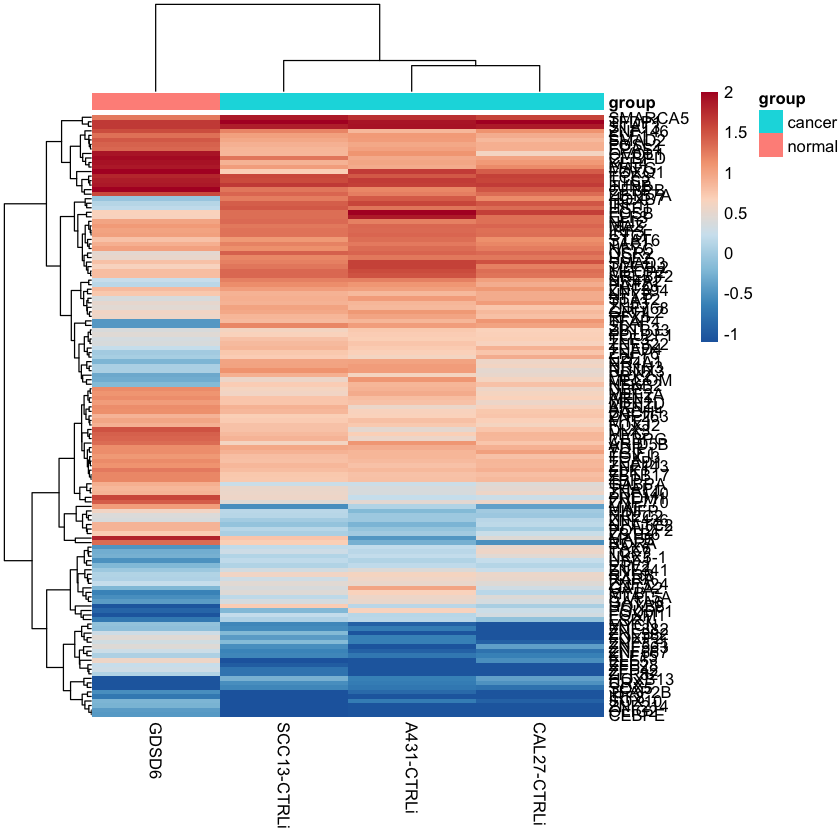

In [23]:
p_with_genes = pheatmap(rna_df_tissue_norm_sig,
             cluster_rows=T,
             cluster_cols=T,
            scale_col=T,
#             fontsize=4,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

save_pheatmap_pdf(p_with_genes, paste0(save_prefix, 'rna_tf_heatmap_by_group.pdf'), width=5, height=20) 

In [24]:
tf_ordering = rownames(rna_df_tissue_norm_sig)[p_with_genes$tree_row[["order"]]]


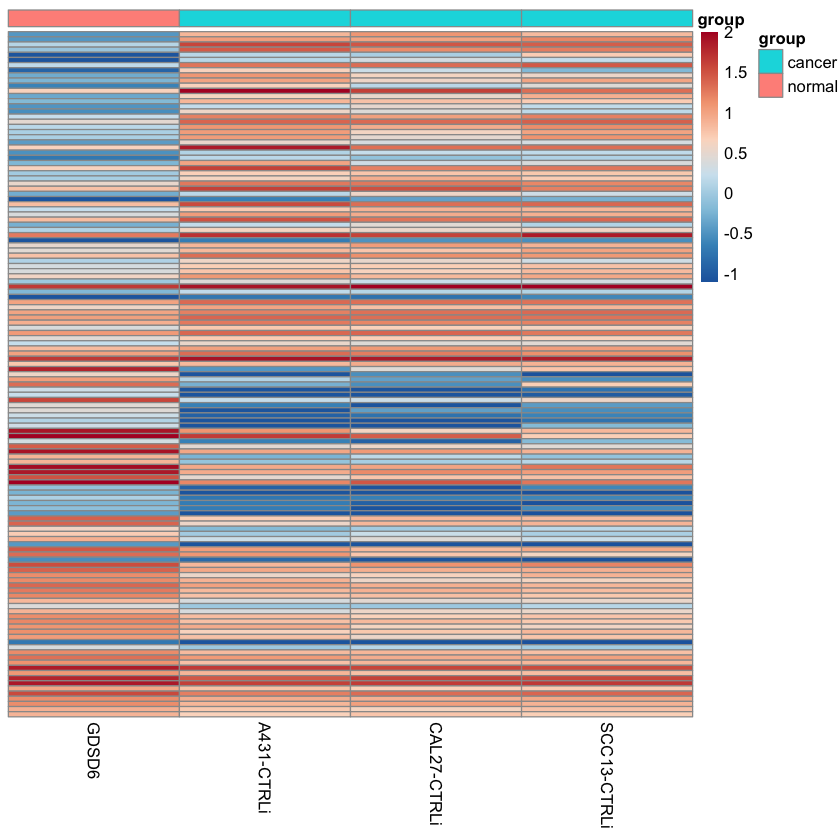

In [25]:
p_no_genes = pheatmap(rna_df_tissue_norm_sig,
             cluster_rows=F,
             cluster_cols=F,
                show_rownames=F,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

# save_pheatmap_png(p_no_genes, paste0(save_prefix, 'rna_heatmap_no_genes.png'), width=3000, height=3000, res = 500) 

# save tf signatures

In [200]:
select_genes[select_genes %in% TF_unique_tissue]

[1] "NR4A1"  "NFKB2"  "ZFP28"  "ZFP82"  "FOXQ1"  "ZNF331" "POU2F2" "ZBTB6" 
 [9] "TFAP2B" "ZNF436"

In [201]:
cancer_TFs= sig_genes_list$cancer[ sig_genes_list$cancer %in% select_genes]
length(cancer_TFs)
normal_TFs = sig_genes_list$normal[ sig_genes_list$normal %in% select_genes]
length(normal_TFs)

all_genes = rownames(rna_df_tissue_norm)
length(all_genes)

[1] 65

[1] 68

[1] 24811

In [202]:
tf_group_df = rbind(data.frame(tf=cancer_TFs,group='cancer'),
      data.frame(tf=normal_TFs,group='normal'))

tf_group_df = tf_group_df %>%
    group_by(tf)%>%
    mutate(group_str = paste0(group, collapse = "|")) %>%
    ungroup()%>%
    dplyr::select(-group)%>%
    distinct()%>%
    column_to_rownames("tf")


In [204]:
# write.table(sort(purple_TFs), file = paste0(save_prefix, "purple_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(green_TFs), file = paste0(save_prefix, "green_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(blue_TFs), file = paste0(save_prefix, "blue_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(grey_TFs), file = paste0(save_prefix, "grey_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(select_genes), file = paste0(save_prefix, "select_TFs.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(all_genes), file = paste0(save_prefix, "all_genes.csv"),row.names=FALSE,col.names=FALSE)


# get gene targets of the tfs (looped regions and promoter regions) and find reactome enrichment

In [205]:
all_entrez = bitr(all_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID


'select()' returned 1:many mapping between keys and columns



In [206]:
# ##RUN ONCE ###
# overall_df = data.frame()
# # for (tissue in normal_tissues){
# #     print(tissue)
# #     tissue_crm_file = paste0('../data/processed/tissue_crms/combined_tissue/',tissue,'_crm.csv')
# #     tissue_crm_df = read.csv(tissue_crm_file,row.names=1)
# #     group = annon_df[tissue,]
# #     tfs_in_group = sort(rownames(tf_group_df)[tf_group_df==group])

# #     for (tf in tfs_in_group){
#         if (tf %in% colnames(tissue_crm_df)){
#             print(tf)
#             target_genes = rownames(tissue_crm_df)[tissue_crm_df[,tf]>0]
#             target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
#             print(length(target_genes_entrez))
#             er = enrichPathway(
#                                 gene = target_genes_entrez, organism = "human", pvalueCutoff = 0.05, pAdjustMethod = "none", qvalueCutoff = 0.5, 
#                                 universe = all_entrez,
#                                 readable      = TRUE
#                             )
            
            
#             er_df = data.frame(er)
#             if (dim(er_df)[1] >0){
#                 er_df$tf = tf
#                 er_df$tissue = tissue
#                 er_df$num_target_genes = length(target_genes_entrez)
#                 rownames(er_df) = NULL
#                 overall_df = rbind(overall_df, er_df)
#             }
#         }
#     }
# }

In [196]:
# write.csv(overall_df,paste0(save_prefix, 'tf_tissue_tg.csv'))

In [210]:
tissue = 'GDSD6'
group = annon_df[tissue,]


In [211]:
group = as.character(annon_df[tissue,])
group
tfs_in_group = sort(rownames(tf_group_df)[tf_group_df=='cancer'])
tfs_in_group

[1] "normal"

[1] "CRX"     "CTCF"    "E2F1"    "ELF3"    "ESR1"    "ETV2"    "FOSB"   
 [8] "FOXM1"   "GATA2"   "GATA6"   "GRHL2"   "HOXB13"  "HOXB7"   "HOXB8"  
[15] "HSF1"    "HSF2"    "IRF1"    "IRF3"    "MAZ"     "MECOM"   "MECP2"  
[22] "MYB"     "NFIC"    "NFKB2"   "NFYB"    "NFYC"    "NKX3-1"  "NR1H3"  
[29] "NR4A1"   "NR4A2"   "OSR2"    "PATZ1"   "PAX6"    "PBX2"    "POU2F1" 
[36] "POU5F1"  "RARA"    "RFX1"    "RUNX3"   "RXRB"    "SIX1"    "SMAD3"  
[43] "SMARCA5" "SOX5"    "SREBF2"  "STAT2"   "STAT3"   "STAT5A"  "STAT6"  
[50] "TAF1"    "TCF7"    "TCF7L2"  "TEAD4"   "TFAP4"   "TFDP1"   "TFE3"   
[57] "TP53"    "USF1"    "ZBTB33"  "ZNF322"  "ZNF324"  "ZNF341"  "ZNF394" 
[64] "ZNF76"   "ZNF768"

In [212]:
##RUN ONCE ###
overall_df_go = data.frame()
for (tissue in sel_tissues){
    print(tissue)
    tissue_crm_file = paste0('../data/processed/tissue_crms/combined_tissue/',tissue,'_crm.csv')
    if (file.exists(tissue_crm_file)){
        tissue_crm_df = read.csv(tissue_crm_file,row.names=1)
        group = as.character(annon_df[tissue,])
        tfs_in_group = sort(rownames(tf_group_df)[tf_group_df==group])

        for (tf in tfs_in_group){
            if (tf %in% colnames(tissue_crm_df)){
                print(tf)
                target_genes = rownames(tissue_crm_df)[tissue_crm_df[,tf]>0]
                target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
                print(length(target_genes_entrez))
                ego <- enrichGO(gene          = target_genes_entrez,
                    universe      = all_entrez,
                    OrgDb         = org.Hs.eg.db,
                    ont           = "BP",
                    pAdjustMethod = "BH",
                    pvalueCutoff  = 0.3,
                    qvalueCutoff  = 0.2)
                er_df = data.frame(ego)
                print(dim(er_df)[1])
                if (dim(er_df)[1] >0){
                    er_df$tf = tf
                    er_df$tissue = tissue
                    er_df$num_target_genes = length(target_genes_entrez)
                    rownames(er_df) = NULL
                    overall_df_go = rbind(overall_df_go, er_df)
                }
            }
        }
    }
}

[1] "A431-CTRLi"
[1] "CTCF"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.14% of input gene IDs are fail to map...”


[1] 724
[1] 0
[1] "E2F1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.12% of input gene IDs are fail to map...”


[1] 864
[1] 0
[1] "ELF3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.12% of input gene IDs are fail to map...”


[1] 828
[1] 0
[1] "FOSB"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 877
[1] 0
[1] "GATA2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.28% of input gene IDs are fail to map...”


[1] 350
[1] 10
[1] "GATA6"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.43% of input gene IDs are fail to map...”


[1] 230
[1] 19
[1] "GRHL2"


'select()' returned 1:1 mapping between keys and columns



[1] 372
[1] 0
[1] "HOXB7"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.4% of input gene IDs are fail to map...”


[1] 248
[1] 0
[1] "HSF1"


'select()' returned 1:1 mapping between keys and columns



[1] 494
[1] 0
[1] "HSF2"


'select()' returned 1:1 mapping between keys and columns



[1] 155
[1] 0
[1] "IRF1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.18% of input gene IDs are fail to map...”


[1] 568
[1] 0
[1] "IRF3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.12% of input gene IDs are fail to map...”


[1] 840
[1] 1
[1] "MAZ"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.08% of input gene IDs are fail to map...”


[1] 1218
[1] 0
[1] "MECOM"


'select()' returned 1:1 mapping between keys and columns



[1] 230
[1] 0
[1] "MECP2"


'select()' returned 1:1 mapping between keys and columns



[1] 383
[1] 0
[1] "MYB"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.38% of input gene IDs are fail to map...”


[1] 263
[1] 0
[1] "NFIC"


'select()' returned 1:1 mapping between keys and columns



[1] 838
[1] 0
[1] "NFKB2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.19% of input gene IDs are fail to map...”


[1] 538
[1] 0
[1] "NFYB"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.18% of input gene IDs are fail to map...”


[1] 542
[1] 0
[1] "NFYC"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.19% of input gene IDs are fail to map...”


[1] 524
[1] 0
[1] "NR1H3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.16% of input gene IDs are fail to map...”


[1] 612
[1] 0
[1] "NR4A1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.24% of input gene IDs are fail to map...”


[1] 421
[1] 0
[1] "NR4A2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.23% of input gene IDs are fail to map...”


[1] 432
[1] 2
[1] "OSR2"


'select()' returned 1:1 mapping between keys and columns



[1] 557
[1] 0
[1] "PATZ1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.08% of input gene IDs are fail to map...”


[1] 1217
[1] 0
[1] "PBX2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.39% of input gene IDs are fail to map...”


[1] 254
[1] 0
[1] "POU2F1"


'select()' returned 1:1 mapping between keys and columns



[1] 345
[1] 2
[1] "POU5F1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.19% of input gene IDs are fail to map...”


[1] 514
[1] 1
[1] "RARA"


'select()' returned 1:1 mapping between keys and columns



[1] 829
[1] 5
[1] "RFX1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.15% of input gene IDs are fail to map...”


[1] 655
[1] 0
[1] "RUNX3"


'select()' returned 1:1 mapping between keys and columns



[1] 419
[1] 5
[1] "RXRB"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.24% of input gene IDs are fail to map...”


[1] 421
[1] 0
[1] "SIX1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.43% of input gene IDs are fail to map...”


[1] 229
[1] 0
[1] "SMAD3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 889
[1] 0
[1] "SMARCA5"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.2% of input gene IDs are fail to map...”


[1] 497
[1] 0
[1] "SREBF2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 920
[1] 0
[1] "STAT2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.16% of input gene IDs are fail to map...”


[1] 625
[1] 0
[1] "STAT3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.29% of input gene IDs are fail to map...”


[1] 343
[1] 19
[1] "STAT5A"


'select()' returned 1:1 mapping between keys and columns



[1] 301
[1] 1
[1] "STAT6"


'select()' returned 1:1 mapping between keys and columns



[1] 365
[1] 0
[1] "TAF1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 936
[1] 0
[1] "TCF7L2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.37% of input gene IDs are fail to map...”


[1] 269
[1] 1
[1] "TEAD4"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.21% of input gene IDs are fail to map...”


[1] 484
[1] 0
[1] "TFAP4"


'select()' returned 1:1 mapping between keys and columns



[1] 424
[1] 0
[1] "TFDP1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 940
[1] 0
[1] "TFE3"


'select()' returned 1:1 mapping between keys and columns



[1] 427
[1] 2
[1] "TP53"


'select()' returned 1:1 mapping between keys and columns



[1] 679
[1] 0
[1] "ZBTB33"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.18% of input gene IDs are fail to map...”


[1] 563
[1] 1
[1] "ZNF322"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.27% of input gene IDs are fail to map...”


[1] 374
[1] 0
[1] "ZNF324"


'select()' returned 1:1 mapping between keys and columns



[1] 599
[1] 0
[1] "ZNF341"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.09% of input gene IDs are fail to map...”


[1] 1101
[1] 0
[1] "ZNF394"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.13% of input gene IDs are fail to map...”


[1] 779
[1] 1
[1] "ZNF76"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.2% of input gene IDs are fail to map...”


[1] 489
[1] 0
[1] "ZNF768"


'select()' returned 1:1 mapping between keys and columns



[1] 416
[1] 0
[1] "CAL27-CTRLi"
[1] "CTCF"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.13% of input gene IDs are fail to map...”


[1] 785
[1] 0
[1] "E2F1"


'select()' returned 1:1 mapping between keys and columns



[1] 935
[1] 0
[1] "ELF3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.12% of input gene IDs are fail to map...”


[1] 821
[1] 11
[1] "FOSB"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 948
[1] 43
[1] "FOXM1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.21% of input gene IDs are fail to map...”


[1] 485
[1] 0
[1] "GATA6"


'select()' returned 1:1 mapping between keys and columns



[1] 229
[1] 0
[1] "GRHL2"


'select()' returned 1:1 mapping between keys and columns



[1] 395
[1] 0
[1] "HOXB7"


'select()' returned 1:1 mapping between keys and columns



[1] 211
[1] 0
[1] "HSF1"


'select()' returned 1:1 mapping between keys and columns



[1] 531
[1] 2
[1] "HSF2"


'select()' returned 1:1 mapping between keys and columns



[1] 174
[1] 0
[1] "IRF1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.16% of input gene IDs are fail to map...”


[1] 612
[1] 0
[1] "IRF3"


'select()' returned 1:1 mapping between keys and columns



[1] 877
[1] 6
[1] "MAZ"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.08% of input gene IDs are fail to map...”


[1] 1315
[1] 21
[1] "MECOM"


'select()' returned 1:1 mapping between keys and columns



[1] 198
[1] 8
[1] "MECP2"


'select()' returned 1:1 mapping between keys and columns



[1] 377
[1] 0
[1] "NFIC"


'select()' returned 1:1 mapping between keys and columns



[1] 936
[1] 0
[1] "NFKB2"


'select()' returned 1:1 mapping between keys and columns



[1] 659
[1] 0
[1] "NFYB"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.17% of input gene IDs are fail to map...”


[1] 590
[1] 0
[1] "NFYC"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.18% of input gene IDs are fail to map...”


[1] 569
[1] 0
[1] "NR1H3"


'select()' returned 1:1 mapping between keys and columns



[1] 642
[1] 0
[1] "NR4A1"


'select()' returned 1:1 mapping between keys and columns



[1] 426
[1] 22
[1] "NR4A2"


'select()' returned 1:1 mapping between keys and columns



[1] 428
[1] 0
[1] "OSR2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.17% of input gene IDs are fail to map...”


[1] 589
[1] 8
[1] "PATZ1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.08% of input gene IDs are fail to map...”


[1] 1302
[1] 1
[1] "PAX6"


'select()' returned 1:1 mapping between keys and columns



[1] 329
[1] 0
[1] "PBX2"


'select()' returned 1:1 mapping between keys and columns



[1] 201
[1] 0
[1] "POU2F1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.3% of input gene IDs are fail to map...”


[1] 333
[1] 11
[1] "RARA"


'select()' returned 1:1 mapping between keys and columns



[1] 870
[1] 0
[1] "RFX1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.14% of input gene IDs are fail to map...”


[1] 723
[1] 0
[1] "RUNX3"


'select()' returned 1:1 mapping between keys and columns



[1] 574
[1] 0
[1] "RXRB"


'select()' returned 1:1 mapping between keys and columns



[1] 499
[1] 20
[1] "SIX1"


'select()' returned 1:1 mapping between keys and columns



[1] 266
[1] 2
[1] "SMAD3"


'select()' returned 1:1 mapping between keys and columns



[1] 971
[1] 8
[1] "SMARCA5"


'select()' returned 1:1 mapping between keys and columns



[1] 493
[1] 0
[1] "SREBF2"


'select()' returned 1:1 mapping between keys and columns



[1] 972
[1] 11
[1] "STAT2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.15% of input gene IDs are fail to map...”


[1] 664
[1] 0
[1] "STAT3"


'select()' returned 1:1 mapping between keys and columns



[1] 394
[1] 1
[1] "STAT5A"


'select()' returned 1:1 mapping between keys and columns



[1] 367
[1] 1
[1] "STAT6"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.25% of input gene IDs are fail to map...”


[1] 395
[1] 1
[1] "TAF1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.1% of input gene IDs are fail to map...”


[1] 982
[1] 0
[1] "TCF7"


'select()' returned 1:1 mapping between keys and columns



[1] 309
[1] 0
[1] "TCF7L2"


'select()' returned 1:1 mapping between keys and columns



[1] 303
[1] 0
[1] "TEAD4"


'select()' returned 1:1 mapping between keys and columns



[1] 510
[1] 11
[1] "TFAP4"


'select()' returned 1:1 mapping between keys and columns



[1] 475
[1] 1
[1] "TFDP1"


'select()' returned 1:1 mapping between keys and columns



[1] 1023
[1] 0
[1] "TFE3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.19% of input gene IDs are fail to map...”


[1] 512
[1] 2
[1] "TP53"


'select()' returned 1:1 mapping between keys and columns



[1] 805
[1] 0
[1] "ZBTB33"


'select()' returned 1:1 mapping between keys and columns



[1] 598
[1] 0
[1] "ZNF322"


'select()' returned 1:1 mapping between keys and columns



[1] 425
[1] 5
[1] "ZNF324"


'select()' returned 1:1 mapping between keys and columns



[1] 667
[1] 0
[1] "ZNF394"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 877
[1] 40
[1] "ZNF76"


'select()' returned 1:1 mapping between keys and columns



[1] 530
[1] 1
[1] "ZNF768"


'select()' returned 1:1 mapping between keys and columns



[1] 479
[1] 6
[1] "GDSD6"
[1] "ARID5B"


'select()' returned 1:1 mapping between keys and columns



[1] 31
[1] 300
[1] "ARNT"


'select()' returned 1:1 mapping between keys and columns



[1] 48
[1] 0
[1] "ARNTL"


'select()' returned 1:1 mapping between keys and columns



[1] 92
[1] 6
[1] "BACH1"


'select()' returned 1:1 mapping between keys and columns



[1] 138
[1] 6
[1] "CEBPB"


'select()' returned 1:1 mapping between keys and columns



[1] 81
[1] 63
[1] "CEBPD"


'select()' returned 1:1 mapping between keys and columns



[1] 95
[1] 10
[1] "CEBPG"


'select()' returned 1:1 mapping between keys and columns



[1] 119
[1] 9
[1] "DBP"


'select()' returned 1:1 mapping between keys and columns



[1] 89
[1] 10
[1] "DLX3"


'select()' returned 1:1 mapping between keys and columns



[1] 32
[1] 0
[1] "ELF1"


'select()' returned 1:1 mapping between keys and columns



[1] 184
[1] 7
[1] "ELF5"


'select()' returned 1:1 mapping between keys and columns



[1] 244
[1] 23
[1] "ELK1"


'select()' returned 1:1 mapping between keys and columns



[1] 150
[1] 0
[1] "EPAS1"


'select()' returned 1:1 mapping between keys and columns



[1] 43
[1] 0
[1] "ETS2"


'select()' returned 1:1 mapping between keys and columns



[1] 321
[1] 10
[1] "FOSL2"


'select()' returned 1:1 mapping between keys and columns



[1] 292
[1] 14
[1] "FOXJ2"


'select()' returned 1:1 mapping between keys and columns



[1] 86
[1] 4
[1] "FOXJ3"


'select()' returned 1:1 mapping between keys and columns



[1] 154
[1] 6
[1] "FOXP2"


'select()' returned 1:1 mapping between keys and columns



[1] 65
[1] 79
[1] "FOXQ1"


'select()' returned 1:1 mapping between keys and columns



[1] 69
[1] 5
[1] "GABPA"


'select()' returned 1:1 mapping between keys and columns



[1] 170
[1] 4
[1] "HINFP"


'select()' returned 1:1 mapping between keys and columns



[1] 18
[1] 378
[1] "JUNB"


'select()' returned 1:1 mapping between keys and columns



[1] 284
[1] 16
[1] "KLF4"


'select()' returned 1:1 mapping between keys and columns



[1] 494
[1] 14
[1] "MAF"


'select()' returned 1:1 mapping between keys and columns



[1] 135
[1] 16
[1] "MAFB"


'select()' returned 1:1 mapping between keys and columns



[1] 102
[1] 6
[1] "MAFG"


'select()' returned 1:1 mapping between keys and columns



[1] 174
[1] 11
[1] "MEF2A"


'select()' returned 1:1 mapping between keys and columns



[1] 69
[1] 16
[1] "MEF2D"


'select()' returned 1:1 mapping between keys and columns



[1] 58
[1] 12
[1] "MTF1"


'select()' returned 1:1 mapping between keys and columns



[1] 27
[1] 6
[1] "MYC"


'select()' returned 1:1 mapping between keys and columns



[1] 92
[1] 2
[1] "NFATC2"


'select()' returned 1:1 mapping between keys and columns



[1] 114
[1] 9
[1] "NR2C2"


'select()' returned 1:1 mapping between keys and columns



[1] 43
[1] 0
[1] "OVOL1"


'select()' returned 1:1 mapping between keys and columns



[1] 21
[1] 1
[1] "POU2F2"


'select()' returned 1:1 mapping between keys and columns



[1] 77
[1] 0
[1] "PRDM1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.62% of input gene IDs are fail to map...”


[1] 160
[1] 16
[1] "RORA"


'select()' returned 1:1 mapping between keys and columns



[1] 96
[1] 6
[1] "SMAD2"


'select()' returned 1:1 mapping between keys and columns



[1] 176
[1] 11
[1] "TBP"


'select()' returned 1:1 mapping between keys and columns



[1] 41
[1] 145
[1] "TCF3"


'select()' returned 1:1 mapping between keys and columns



[1] 154
[1] 3
[1] "TEAD1"


'select()' returned 1:1 mapping between keys and columns



[1] 135
[1] 12
[1] "TGIF1"


'select()' returned 1:1 mapping between keys and columns



[1] 47
[1] 46
[1] "THAP1"


'select()' returned 1:1 mapping between keys and columns



[1] 212
[1] 0
[1] "VDR"


'select()' returned 1:1 mapping between keys and columns



[1] 144
[1] 13
[1] "ZBTB17"


'select()' returned 1:1 mapping between keys and columns



[1] 452
[1] 29
[1] "ZBTB6"


'select()' returned 1:1 mapping between keys and columns



[1] 143
[1] 16
[1] "ZBTB7A"


'select()' returned 1:1 mapping between keys and columns



[1] 56
[1] 19
[1] "ZNF140"


'select()' returned 1:1 mapping between keys and columns



[1] 38
[1] 213
[1] "ZNF143"


'select()' returned 1:1 mapping between keys and columns



[1] 63
[1] 0
[1] "ZNF146"


'select()' returned 1:1 mapping between keys and columns



[1] 28
[1] 0
[1] "ZNF263"


'select()' returned 1:1 mapping between keys and columns



[1] 505
[1] 11
[1] "ZNF436"


'select()' returned 1:1 mapping between keys and columns



[1] 106
[1] 6
[1] "ZNF563"


'select()' returned 1:1 mapping between keys and columns



[1] 221
[1] 0
[1] "ZNF770"


'select()' returned 1:1 mapping between keys and columns



[1] 456
[1] 6
[1] "SCC13-CTRLi"
[1] "CTCF"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.15% of input gene IDs are fail to map...”


[1] 648
[1] 0
[1] "E2F1"


'select()' returned 1:1 mapping between keys and columns



[1] 773
[1] 0
[1] "ELF3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.15% of input gene IDs are fail to map...”


[1] 651
[1] 0
[1] "FOSB"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.12% of input gene IDs are fail to map...”


[1] 820
[1] 7
[1] "GATA2"


'select()' returned 1:1 mapping between keys and columns



[1] 256
[1] 0
[1] "GATA6"


'select()' returned 1:1 mapping between keys and columns



[1] 165
[1] 17
[1] "GRHL2"


'select()' returned 1:1 mapping between keys and columns



[1] 317
[1] 0
[1] "HOXB7"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.48% of input gene IDs are fail to map...”


[1] 209
[1] 0
[1] "HOXB8"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.6% of input gene IDs are fail to map...”


[1] 167
[1] 0
[1] "HSF1"


'select()' returned 1:1 mapping between keys and columns



[1] 457
[1] 0
[1] "HSF2"


'select()' returned 1:1 mapping between keys and columns



[1] 155
[1] 0
[1] "IRF1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.22% of input gene IDs are fail to map...”


[1] 445
[1] 0
[1] "IRF3"


'select()' returned 1:1 mapping between keys and columns



[1] 750
[1] 0
[1] "MAZ"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.08% of input gene IDs are fail to map...”


[1] 1270
[1] 3
[1] "MECOM"


'select()' returned 1:1 mapping between keys and columns



[1] 168
[1] 0
[1] "MECP2"


'select()' returned 1:1 mapping between keys and columns



[1] 298
[1] 0
[1] "MYB"


'select()' returned 1:1 mapping between keys and columns



[1] 213
[1] 0
[1] "NFIC"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.12% of input gene IDs are fail to map...”


[1] 805
[1] 0
[1] "NFKB2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.2% of input gene IDs are fail to map...”


[1] 487
[1] 16
[1] "NFYB"


'select()' returned 1:1 mapping between keys and columns



[1] 475
[1] 0
[1] "NFYC"


'select()' returned 1:1 mapping between keys and columns



[1] 449
[1] 0
[1] "NR1H3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.19% of input gene IDs are fail to map...”


[1] 513
[1] 0
[1] "NR4A1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.28% of input gene IDs are fail to map...”


[1] 353
[1] 0
[1] "NR4A2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.3% of input gene IDs are fail to map...”


[1] 328
[1] 0
[1] "OSR2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.21% of input gene IDs are fail to map...”


[1] 467
[1] 0
[1] "PATZ1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.08% of input gene IDs are fail to map...”


[1] 1252
[1] 0
[1] "PBX2"


'select()' returned 1:1 mapping between keys and columns



[1] 175
[1] 0
[1] "POU2F1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.38% of input gene IDs are fail to map...”


[1] 263
[1] 0
[1] "RARA"


'select()' returned 1:1 mapping between keys and columns



[1] 742
[1] 1
[1] "RFX1"


'select()' returned 1:1 mapping between keys and columns



[1] 564
[1] 0
[1] "RUNX3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.27% of input gene IDs are fail to map...”


[1] 376
[1] 0
[1] "RXRB"


'select()' returned 1:1 mapping between keys and columns



[1] 401
[1] 1
[1] "SIX1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.5% of input gene IDs are fail to map...”


[1] 199
[1] 6
[1] "SMAD3"


'select()' returned 1:1 mapping between keys and columns



[1] 828
[1] 0
[1] "SMARCA5"


'select()' returned 1:1 mapping between keys and columns



[1] 394
[1] 0
[1] "SREBF2"


'select()' returned 1:1 mapping between keys and columns



[1] 845
[1] 0
[1] "STAT2"


'select()' returned 1:1 mapping between keys and columns



[1] 485
[1] 2
[1] "STAT3"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.31% of input gene IDs are fail to map...”


[1] 317
[1] 0
[1] "STAT6"


'select()' returned 1:1 mapping between keys and columns



[1] 368
[1] 0
[1] "TAF1"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.11% of input gene IDs are fail to map...”


[1] 902
[1] 0
[1] "TCF7L2"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.5% of input gene IDs are fail to map...”


[1] 201
[1] 0
[1] "TEAD4"


'select()' returned 1:1 mapping between keys and columns



[1] 426
[1] 0
[1] "TFAP4"


'select()' returned 1:1 mapping between keys and columns



[1] 357
[1] 0
[1] "TFDP1"


'select()' returned 1:1 mapping between keys and columns



[1] 875
[1] 0
[1] "TFE3"


'select()' returned 1:1 mapping between keys and columns



[1] 368
[1] 0
[1] "TP53"


'select()' returned 1:1 mapping between keys and columns



[1] 605
[1] 0
[1] "ZBTB33"


'select()' returned 1:1 mapping between keys and columns



[1] 495
[1] 0
[1] "ZNF322"


'select()' returned 1:1 mapping between keys and columns



[1] 300
[1] 0
[1] "ZNF324"


'select()' returned 1:1 mapping between keys and columns



[1] 543
[1] 0
[1] "ZNF341"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.09% of input gene IDs are fail to map...”


[1] 1083
[1] 2
[1] "ZNF394"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.13% of input gene IDs are fail to map...”


[1] 777
[1] 0
[1] "ZNF76"


'select()' returned 1:1 mapping between keys and columns



[1] 400
[1] 0
[1] "ZNF768"


'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(target_genes, fromType = "SYMBOL", toType = "ENTREZID", :
“0.28% of input gene IDs are fail to map...”


[1] 351
[1] 0


In [213]:
write.csv(overall_df_go,paste0(save_prefix, 'tf_tissue_tg_go.csv'))

# stop and run SCC AND MELANOMA through this pipeline


# go BP

In [28]:
save_prefix = '../data/processed/fig6_footprinting/'

In [29]:
tissue_colors = read.csv(paste0('../data/processed/fig3_footprinting/', 'tissue_colors.csv'))

In [30]:
overall_df_go_mc = read.csv(paste0(save_prefix, 'mc_tf_tissue_tg_go.csv'),row.names=1,stringsAsFactors=F)#,stringAsFactors=F)


In [31]:
overall_df_go_scc = read.csv(paste0(save_prefix, 'scc_tf_tissue_tg_go.csv'),row.names=1,stringsAsFactors=F)#,stringAsFactors=F)


In [32]:
# num of descriptions that are significant
length(unique(overall_df_go_mc[overall_df_go_mc[["p.adjust"]] < 0.05,]$Description))

[1] 227

### manually choose some go descriptions to include (for both scc and mc)

In [33]:
indices_picked_mc = read.csv('../data//processed/fig6_footprinting/mc_tf_tissue_tg_go_filt.csv')$Column1
descriptions_picked_mc = sort(unique(overall_df_go_mc[indices_picked_mc,'Description']))
length(descriptions_picked_mc)
tfs_picked_mc = sort(unique(overall_df_go_mc[indices_picked_mc,'tf']))
length(tfs_picked_mc)
overall_df_go_mc_filt = overall_df_go_mc[indices_picked_mc,]

[1] 17

[1] 14

In [34]:
indices_picked_scc = read.csv('../data//processed/fig6_footprinting/scc_tf_tissue_tg_go_filt.csv')$Column1
descriptions_picked_scc = sort(unique(overall_df_go_scc[indices_picked_scc,'Description']))
length(descriptions_picked_scc)
tfs_picked_scc = sort(unique(overall_df_go_scc[indices_picked_scc,'tf']))
length(tfs_picked_scc)
overall_df_go_scc_filt = overall_df_go_scc[indices_picked_scc,]

[1] 14

[1] 60

In [35]:
overall_df_go_filt = rbind(overall_df_go_mc_filt,overall_df_go_scc_filt)
dim(overall_df_go_filt)
length(unique(overall_df_go_filt$tf))
length(unique(overall_df_go_filt$Description))

[1] 201  12

[1] 70

[1] 30

In [43]:
# overall_df_go_filt = filter(overall_df_go, Description %in% descriptions_picked)
# overall_df_go_filt = filter(overall_df_go_filt, tf %in% tfs_picked)
overall_df_go_filt$log10_pval = -log10(overall_df_go_filt[['p.adjust']]+1e-2)


In [ ]:
# groups_df = rna_genes_result_normal%>% dplyr::select(tissues,group)%>%unique()
# groups_df$tissues = as.character(groups_df$tissues)
# rownames(groups_df) = NULL
# groups_df[groups_df$group=='purple',]

In [ ]:
# select_group = function(df,group_str){
#     df_group = df%>%
#         left_join(groups_df, by=c('tissue'='tissues'))%>%
#         filter(group==group_str)%>%
#         mutate(pvalue = pmin(1,pvalue*dim(groups_df[groups_df$group==group_str,])[1]))%>%
# #         filter(pvalue<.05)%>%
#         dplyr::select('Description','tissue','pvalue','tf')%>%
#         group_by(tf,Description)%>%
#         summarise(pval = min(pvalue), n= n())%>%
#         mutate(pval_correct = pmin(1, pval*n))%>%
# #         filter(pval_correct<0.05)%>%
#         mutate(group = group_str)
# }

In [ ]:
# overall_df_go_purple = select_group(overall_df_go_filt, 'purple')
# dim(overall_df_go_purple)
# overall_df_go_grey = select_group(overall_df_go_filt, 'grey')
# dim(overall_df_go_grey)
# overall_df_go_green = select_group(overall_df_go_filt, 'green')
# dim(overall_df_go_green)
# overall_df_go_blue = select_group(overall_df_go_filt, 'blue')
# dim(overall_df_go_blue)

In [ ]:
# overall_df_regrouped_go = rbind(overall_df_go_purple, overall_df_go_grey, overall_df_go_green, overall_df_go_blue)
# overall_df_regrouped_go = overall_df_regrouped_go%>%
#     group_by(tf, Description)%>%
#     summarise(pval = min(pval_correct), n= n())%>%
#     mutate(pval_correct = pmin(1, pval*n))%>%
#     filter(pval_correct<0.05)%>%
#     arrange(pval_correct)%>%
#     mutate(log10_pval = -log10(pval_correct))
# overall_df_regrouped_go$Description = as.character(overall_df_regrouped_go$Description)

In [ ]:
# length(unique(overall_df_regrouped_go$tf))

### re order and filter the rna expression

In [48]:
save_prefix

[1] "../data/processed/fig6_footprinting/"

In [44]:
# select_tfs_post_go_term = rownames(overall_df_regrouped_go_spread)
# select_tfs_post_go_term =unique(overall_df_regrouped_go$tf)# tf_df$tf
select_tfs_post_go_term =unique(overall_df_go_filt$tf)# tf_df$tf

length(select_tfs_post_go_term)

[1] 70

In [51]:
rna_df_tissue_order = c('GDSD6','A431-CTRLi','CAL27-CTRLi','SCC13-CTRLi',
                      'Melanocytes', 'COLO_SCR_DMSO','SKMEL5_SCR_DMSO','WM_SCR_DMSO')
annon_df =data.frame(group = c('normal', 'cancer', 'cancer', 'cancer', 'normal', 'cancer', 'cancer', 'cancer'))
rownames(annon_df) = rna_df_tissue_order

In [52]:
rna_df_tissue_tf_normal = rna_df_tissue[select_tfs_post_go_term,rna_df_tissue_order]
rna_df_tissue_tf_normal_log = log2(rna_df_tissue_tf_normal+1e-2)
rna_df_tissue_tf_normal_log_norm = as.data.frame(scale(rna_df_tissue_tf_normal_log, center = TRUE, scale = TRUE))
rna_df_tissue_tf_normal_log_norm[rna_df_tissue_tf_normal_log_norm< (-2)] = -2
rna_df_tissue_tf_normal_log_norm[rna_df_tissue_tf_normal_log_norm> (2)] = 2
# rna_df_tissue_tf_normal_log_norm = rna_df_tissue_tf_normal_log_norm[apply(rna_df_tissue_tf_normal_log_norm,1,max)>0 ,]
# rna_df_tissue_tf_normal_log_norm = rna_df_tissue_tf_normal_log_norm[apply(rna_df_tissue_tf_normal_log_norm,1,sum)< 14,]
# rna_df_tissue_tf_normal_log_norm = rna_df_tissue_tf_normal_log_norm[apply(rna_df_tissue_tf_normal_log_norm,1,sd)>0.2 ,]

pdf 
  2

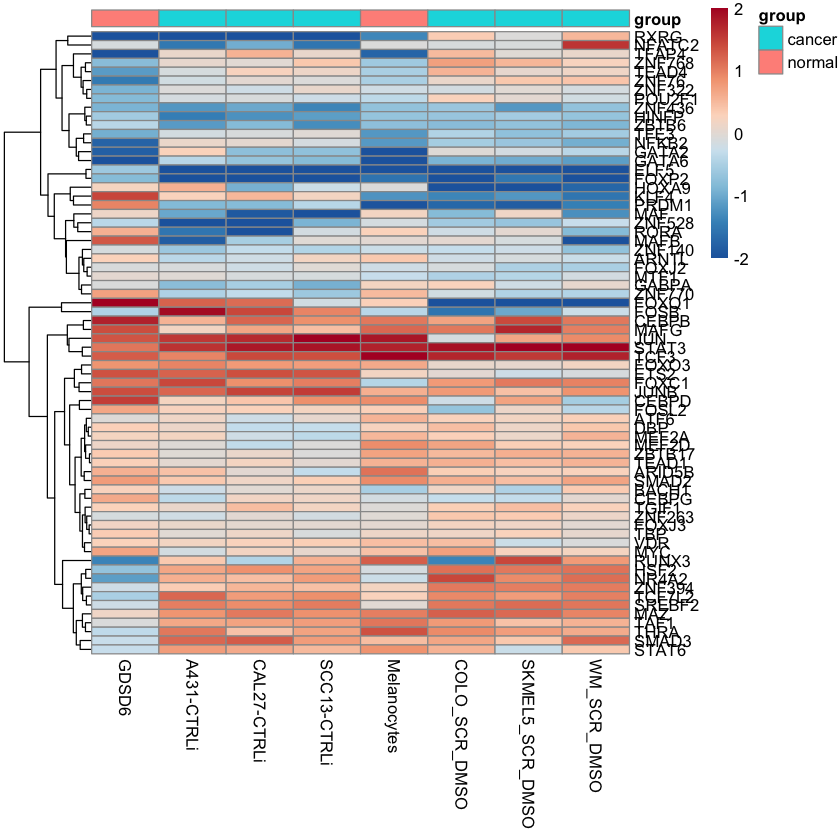

In [54]:
p_with_genes = pheatmap(rna_df_tissue_tf_normal_log_norm,
             cluster_rows=T,
             cluster_cols=F,
            scale_row=T,
            scale_col=T,
#             fontsize=4,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

save_pheatmap_pdf(p_with_genes, paste0(save_prefix, 'rna_tf_heatmap_by_group_post_goterm.pdf'), width=6, height=15) 

In [55]:
tf_ordering = rownames(rna_df_tissue_tf_normal_log_norm)[p_with_genes$tree_row[["order"]]]
length(tf_ordering)

[1] 70

In [ ]:
# overall_df_regrouped_go_spread = overall_df_regrouped_go%>%
#     dplyr::select('Description','pval_correct','tf')%>%
#     spread('Description', 'pval_correct', fill = 0, convert = FALSE)
# overall_df_regrouped_go_spread = column_to_rownames(overall_df_regrouped_go_spread,"tf")
# overall_df_regrouped_go_spread = overall_df_regrouped_go_spread[tf_ordering,]
# # overall_df_regrouped_go_spread_highVar = overall_df_regrouped_go_spread_highVar[tf_ordering,]

In [61]:
# overall_df_regrouped_go = rbind(overall_df_go_purple, overall_df_go_grey, overall_df_go_green, overall_df_go_blue)
# overall_df_regrouped_go = overall_df_regrouped_go%>%
# #     group_by(tf, Description)%>%
# #     summarise(pval = min(pval_correct), n= n())%>%
# #     mutate(pval_correct = pmin(1, pval*n))%>%
# #     filter(pval_correct<0.05)%>%
# #     arrange(pval_correct)%>%
#     mutate(log10_pval = -log10(pval_correct))
# overall_df_regrouped_go$Description = as.character(overall_df_regrouped_go$Description)



In [62]:
overall_df_regrouped_go_reduced = overall_df_go_filt %>% 
    group_by(tf, Description) %>% 
    filter(log10_pval == min(log10_pval)) %>%
    filter(1:n() == 1)
overall_df_regrouped_go_spread = overall_df_regrouped_go_reduced%>%
    dplyr::select('Description','log10_pval','tf')%>%
    spread('Description', 'log10_pval', fill = 0, convert = FALSE)
# rownames(overall_df_regrouped_spread) = overall_df_regrouped_spread$tf
overall_df_regrouped_go_spread = column_to_rownames(overall_df_regrouped_go_spread,"tf")


pdf 
  2

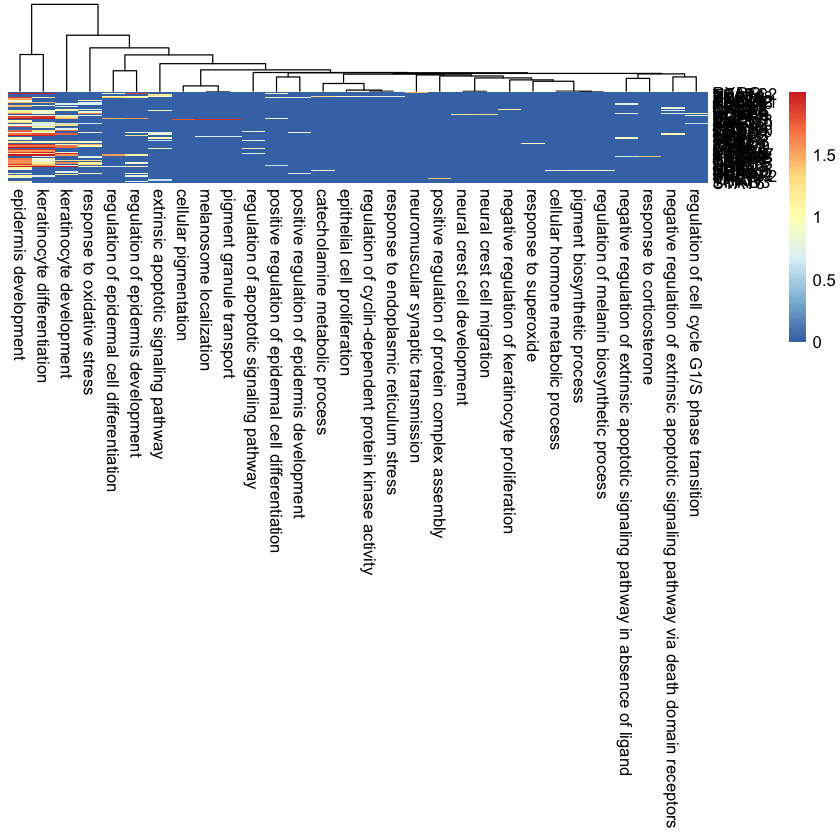

In [70]:
p_go = pheatmap(overall_df_regrouped_go_spread[tf_ordering,],
        cluster_rows=F)

save_pheatmap_pdf(p_go, paste0(save_prefix, 'overall_df_regrouped_go_spread.pdf'), width=8, height=18) 

In [71]:
go_term_ordering = colnames(overall_df_regrouped_go_spread)[p_go$tree_col[["order"]]]
go_term_ordering_sel = go_term_ordering
# go_term_ordering_sel = go_term_ordering[c(1:3,5:9,13,20,27:29,38:51,56:91)]
# # go_term_ordering_sel = go_term_ordering[c(1:3,5:9,13,18,27:28,30,39:63)]

In [ ]:
# write.csv(go_term_ordering_sel,paste0(save_prefix,'go_term_ordering_sel.csv'))
# go_term_ordering_sel= as.character(read.csv(paste0(save_prefix,'go_term_ordering_sel.csv'))$x)
# go_term_ordering_sel

pdf 
  2

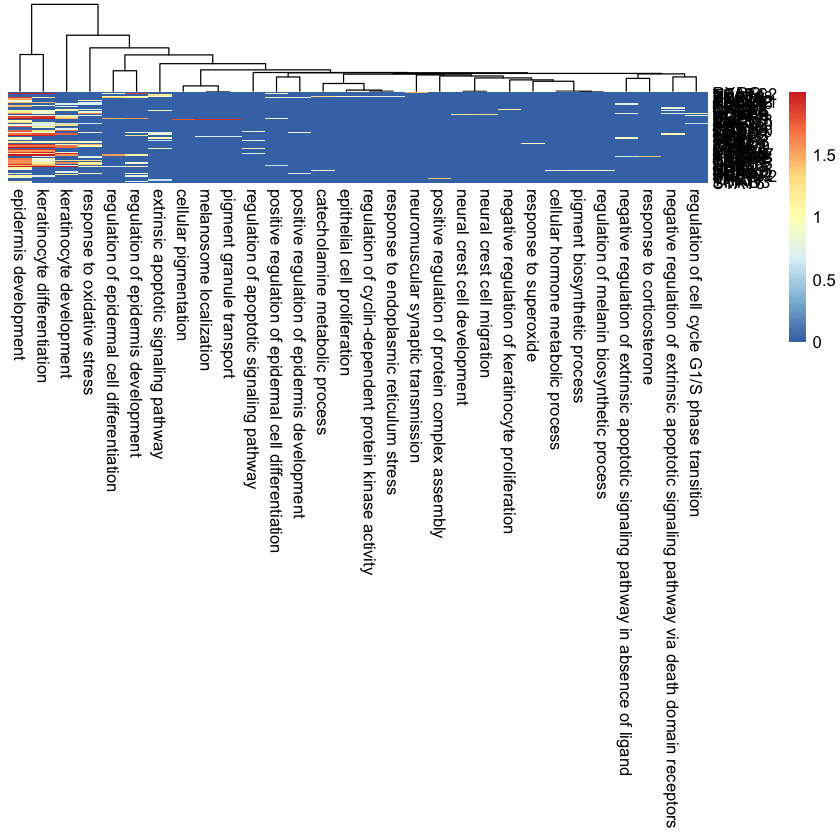

In [73]:
p_go_sel = pheatmap(overall_df_regrouped_go_spread[tf_ordering,go_term_ordering_sel],
        cluster_rows=F)

save_pheatmap_pdf(p_go_sel, paste0(save_prefix, 'overall_df_regrouped_go_spread_sel.pdf'), width=8, height=18) 

In [74]:
dim(overall_df_regrouped_go_spread[tf_ordering,go_term_ordering_sel])

[1] 70 30

### color by tissue

MC = #2B3990 (all cell lines)
SCC = #662D91 (all cell lines)

In [82]:
tissues = unique(overall_df_go_filt$tissue)
col_arr = c("#2B3990","#2B3990","#189BDD","#662D91","#662D91",'#A22633',"#662D91")

In [95]:
tissue_colors = data.frame(tissue=tissues, color=col_arr)

tissue_order = as.character(tissue_colors$tissue)
color_order = as.character(tissue_colors$color)


In [84]:
overall_df_go_filt_with_groups = overall_df_go_filt%>%
#     left_join(groups_df, by=c('tissue'='tissues'))%>%
    left_join(tissue_colors, by='tissue')%>%
#     mutate(log10_pval=-log10(p.adjust))%>%
    filter(Description %in% go_term_ordering_sel)%>%
    filter(tf %in% tf_ordering)
dim(overall_df_go_filt_with_groups)
# overall_df_go_filt_with_groups    


Warning message:
“Column `tissue` joining character vector and factor, coercing into character vector”


[1] 201  14

In [86]:
write.csv(overall_df_go_filt_with_groups, paste0(save_prefix,'overall_df_go_filt_with_groups.csv'))

In [87]:
overall_df_go_filt_with_groups = read.csv(paste0(save_prefix,'overall_df_go_filt_with_groups.csv'),stringsAsFactor=F)
dim(overall_df_go_filt_with_groups)

[1] 201  15

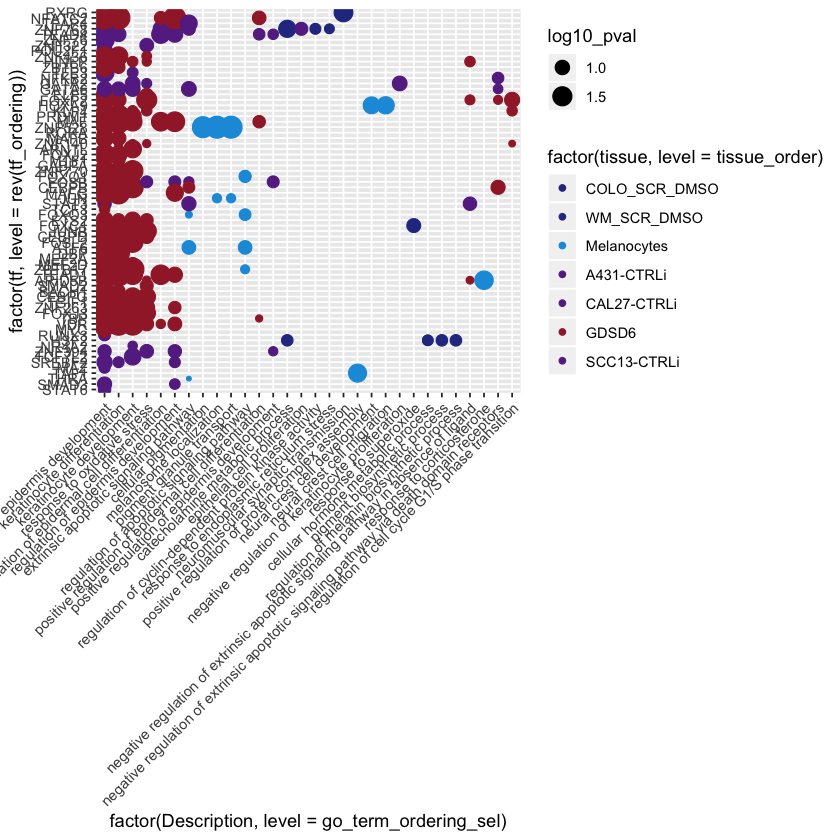

In [97]:
p_dot_tissue = ggplot(overall_df_go_filt_with_groups, aes(x=factor(Description,level=go_term_ordering_sel), y = factor(tf,level=rev(tf_ordering)),
                                                   color=factor(tissue, level=tissue_order)))+
    geom_point(aes(size=log10_pval))+
    scale_color_manual(values=color_order)+
    theme(axis.text.x = element_text(angle = 45,hjust=1))
p_dot_tissue
ggsave(file = paste0(save_prefix, "overall_df_regrouped_go_reduced_bytissue.eps"),height=20, width=12)
# # level_order <- c('virginica', 'versicolor', 'setosa') #this vector might be useful for other plots/analyses
# ggplot(overall_df_regrouped_go, aes(x = factor(Description, y = tf)) + 
#      geom_point(aes( size=log10_pval)) +#,colour="black",pch=21)
#   theme(axis.text.x = element_text(angle = 45))
# #   scale_size_area(max_size = 10)

### color by group

In [ ]:
# check to make sure all tfs are preserved
overall_df_regrouped_go_reduced = overall_df_regrouped_go_reduced%>%
    filter(Description %in% go_term_ordering_sel)%>%
    filter(tf %in% tf_ordering)
overall_df_regrouped_go_reduced%>%
    group_by(tf)%>%
    summarise(n())%>%dim()

In [ ]:
p_dot = ggplot(overall_df_regrouped_go_reduced, aes(x=factor(Description,level=go_term_ordering_sel), y = factor(tf,level=tf_ordering),
                                                   color=group))+
    geom_point(aes(size=log10_pval))+
    scale_color_manual(values=c("blue", "lightgreen", "grey","purple"))+
    theme(axis.text.x = element_text(angle = 45,hjust=1))
p_dot
ggsave(file = paste0(save_prefix, "overall_df_regrouped_go_reduced.eps"),height=20, width=15)
# # level_order <- c('virginica', 'versicolor', 'setosa') #this vector might be useful for other plots/analyses
# ggplot(overall_df_regrouped_go, aes(x = factor(Description, y = tf)) + 
#      geom_point(aes( size=log10_pval)) +#,colour="black",pch=21)
#   theme(axis.text.x = element_text(angle = 45))
# #   scale_size_area(max_size = 10)

In [ ]:
dim(-log10(overall_df_regrouped_go_spread[,descr_plus_2]))
p_go_highvar = pheatmap(-log10(overall_df_regrouped_go_spread_highVar),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_go_highvar, paste0(save_prefix, 'overall_df_regrouped_go_spread_highVar.pdf'), width=15, height=15) 

In [ ]:
p_go_highvar = pheatmap(-log10(overall_df_regrouped_go_spread_highVar),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_go_highvar, paste0(save_prefix, 'overall_df_regrouped_go_spread_highVar.pdf'), width=15, height=15) 

In [ ]:
p_with_genes_after_go = pheatmap(rna_df_tissue_norm_sig[[,
             cluster_rows=T,
             cluster_cols=T,
            scale_col=T,
#             fontsize=4,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))

save_pheatmap_png(p_with_genes, paste0(save_prefix, 'rna_tf_heatmap_by_group.png'), width=1200, height=4000, res = 200) 

# Reactome

In [ ]:
overall_df = read.csv(paste0(save_prefix, 'tf_tissue_tg.csv'),row.names=1)

In [ ]:
head(overall_df)
dim(overall_df)

In [ ]:
overall_df$tissue = as.character(overall_df$tissue)

In [ ]:
overall_df_purple = select_group(overall_df, 'purple')
dim(overall_df_purple)
overall_df_grey = select_group(overall_df, 'grey')
dim(overall_df_grey)
overall_df_green = select_group(overall_df, 'green')
dim(overall_df_green)
overall_df_blue = select_group(overall_df, 'blue')
dim(overall_df_blue)

In [ ]:
overall_df_regrouped = rbind(overall_df_purple, overall_df_grey, overall_df_green, overall_df_blue)
overall_df_regrouped = overall_df_regrouped%>%
    group_by(tf, Description)%>%
    summarise(pval = min(pval_correct), n= n())%>%
    mutate(pval_correct = pmin(1, pval*n))%>%
    filter(pval_correct<0.05)%>%
    arrange(pval_correct)


In [ ]:
# overall_df_purple[overall_df_purple$tf %in% purple_TFs,]%>%arrange(pval_correct)%>%head(10)
# overall_df_purple%>%arrange(pval_correct)%>%head(10)

In [ ]:
overall_df_regrouped_spread = overall_df_regrouped%>%
    dplyr::select('Description','pval_correct','tf')%>%
    spread('Description', 'pval_correct', fill = 1, convert = FALSE)
# rownames(overall_df_regrouped_spread) = overall_df_regrouped_spread$tf
overall_df_regrouped_spread = column_to_rownames(overall_df_regrouped_spread,"tf")

# get ordering of tfs that matches above heatmap
select_tfs_post_enrich = tf_ordering[tf_ordering %in% rownames(overall_df_regrouped_spread)]
length(select_tfs_post_enrich)

overall_df_regrouped_spread = overall_df_regrouped_spread[select_tfs_post_enrich,]
dim(overall_df_regrouped_spread)

if (length(nearZeroVar(overall_df_regrouped_spread)) > 0) {
  overall_df_regrouped_spread_highVar <- overall_df_regrouped_spread[, -nearZeroVar(overall_df_regrouped_spread)]
}
rownames(overall_df_regrouped_spread_highVar) = select_tfs_post_enrich
dim(overall_df_regrouped_spread_highVar)

In [ ]:
p_reactome = pheatmap(-log10(overall_df_regrouped_spread),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_reactome, paste0(save_prefix, 'overall_df_regrouped_spread.pdf'), width=100, height=20) 

In [ ]:

colnames(overall_df_regrouped_spread)

In [ ]:
p_reactome_highvar = pheatmap(-log10(overall_df_regrouped_spread_highVar),
        cluster_rows=T,
                      annotation_row=tf_group_df)

save_pheatmap_pdf(p_reactome_highvar, paste0(save_prefix, 'overall_df_regrouped_spread_highVar.pdf'), width=30, height=20) 

In [ ]:
select_tfs_post_enrich = select_genes[select_genes %in% rownames(tf_by_reactome_pval_mean)]

In [ ]:
# if (length(nearZeroVar(tf_by_reactome_pval_mean)) > 0) {
#   tf_by_reactome_pval_mean_highVarCol <- tf_by_reactome_pval_mean[select_tfs_post_enrich, -nearZeroVar(tf_by_reactome_pval_mean)]
# }
# rownames(tf_by_reactome_pval_mean_highVarCol) = select_tfs_post_enrich

In [ ]:
dim(tf_by_reactome_pval_mean_highVarCol)

In [ ]:
p_reactome = pheatmap(-log2(tf_by_reactome_pval_mean_highVarCol),
        cluster_rows=F)

save_pheatmap_pdf(p_reactome, paste0(save_prefix, 'tf_by_reactome_pval_mean_highVarCol.pdf'), width=50, height=20) 

In [ ]:
# tf_by_reactome_pval_mean[select_tfs_post_enrich,]

In [ ]:
tissue = 'GDSD6'
tissue_crm_file = paste0('../data/processed/tissue_crms/combined_tissue/',tissue,'_crm.csv')
tissue_crm_df = read.csv(tissue_crm_file,row.names=1)
head(tissue_crm_df)

In [ ]:
length(select_genes)
tf = 'TP63'#select_genes[2] #PRDM1
tf

In [ ]:
tf %in% colnames(tissue_crm_df)

In [ ]:
target_genes = rownames(tissue_crm_df)[tissue_crm_df[,tf]>0]
write.csv(target_genes,paste0(save_dir, tf,'_',tissue,'_target_genes.csv'))
target_genes_entrez = bitr(target_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
length(target_genes_entrez)

In [ ]:
ego <- enrichGO(gene          = target_genes_entrez,
                universe      = all_entrez,
                OrgDb         = org.Hs.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.2)#,
#         readable      = TRUE)
dim(ego)
head(ego)

In [ ]:
er = enrichPathway(
    gene = target_genes_entrez, organism = "human", pvalueCutoff = 0.05, pAdjustMethod = "none", qvalueCutoff = 0.5, 
    universe = all_entrez,
    readable      = TRUE
)

In [ ]:
er_df = data.frame(er)
dim(er_df)
er_df$tf = tf
er_df$tissue = tissue
rownames(er_df) = NULL
head(er_df)

In [ ]:
dotplot(er)